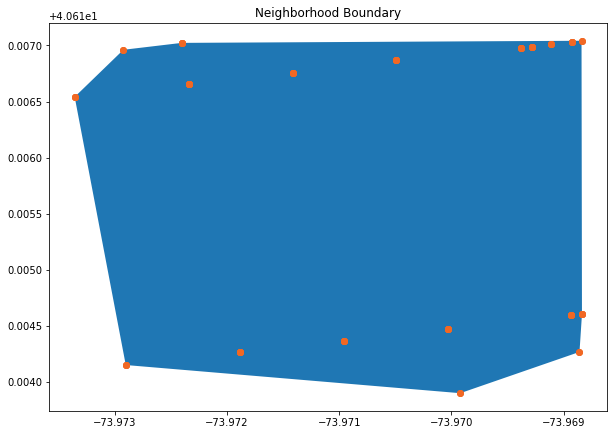

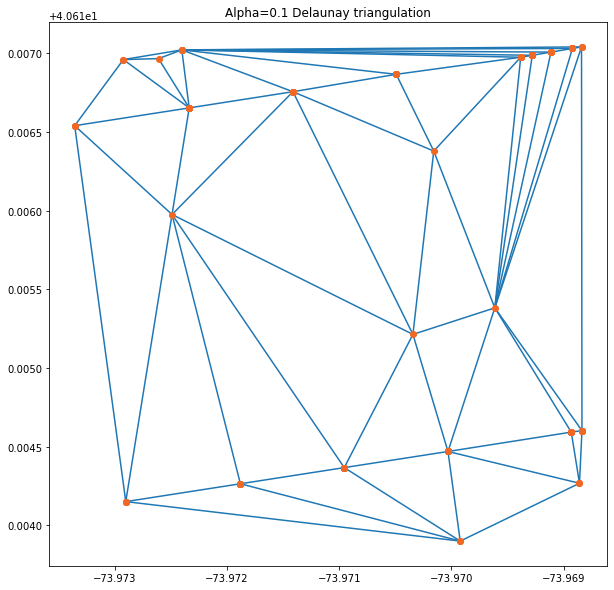

In [92]:
import os
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from geopy import distance
import sys
import random
from tqdm import tqdm
import osmnx as ox
from shapely.geometry import Point, Polygon
from geopandas import GeoSeries
from shapely.ops import cascaded_union, polygonize_full
import geopandas as gpd
import shapely
from pprint import pprint
import shapely.geometry as geometry
import pylab as pl
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.ops import cascaded_union, polygonize
from scipy.spatial import Delaunay
import numpy as np
import math
from matplotlib.collections import LineCollection


streetscore_data_folder = '/home/rchen/Documents/github/airbnb_crime/data/streetscore_dataset'
streetscore_boston_file = 'streetscore_boston.csv'
streetscore_nyc_file = 'streetscore_newyorkcity.csv'

review_nyc_file = 'rscore_nyc.csv'

class FixedSizeBuffer:
    def __init__(self, node, buffer_size):
        self.source_node = node
        self.buffer_size = buffer_size  # metric: meters
        self.neighborhood_gdf = ox.graph_to_gdfs(ox.graph_from_point(self.source_node, dist=self.buffer_size, network_type='all'), nodes=False, fill_edge_geometry=True)
        self.neighborhood_geometry = self.neighborhood_gdf['geometry'] # long first, lat second
        self.vertices = []
        for item in self.neighborhood_geometry:
            points = item.boundary
            self.vertices += list(points)
        self.x = [point.coords[0][0] for point in self.vertices]
        self.y = [point.coords[0][1] for point in self.vertices]
        self.populated_vertices = []
        self.populated_x = []
        self.populated_y = []
        
    @staticmethod
    def plot_points(x, y):
        pl.figure(figsize=(10,10))
        _ = pl.plot(x,y,'o', color='#f16824')

    def alpha_shape(self, alpha, n=100):
        """
        Compute the alpha shape (concave hull) of a set
        of points.
        @param points: Iterable container of points.
        @param alpha: alpha value to influence the
            gooeyness of the border. Smaller numbers
            don't fall inward as much as larger numbers.
            Too large, and you lose everything!
        """
        self.populate_points(n)
        if len(self.populated_vertices) < 4:
            # When you have a triangle, there is no sense
            # in computing an alpha shape.
            return geometry.MultiPoint(list(points)).convex_hull
        coords = np.array([point.coords[0]
                           for point in self.populated_vertices])
        tri = Delaunay(coords)
        edges = set()
        edge_points = []
        # loop over triangles:
        # ia, ib, ic = indices of corner points of the
        # triangle
        for ia, ib, ic in tri.vertices:
            pa = coords[ia]
            pb = coords[ib]
            pc = coords[ic]
            # Lengths of sides of triangle
            a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
            b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
            c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)
            # Semiperimeter of triangle
            s = (a + b + c)/2.0
            # Area of triangle by Heron's formula
            area = math.sqrt(s*(s-a)*(s-b)*(s-c)+0.00001)
            circum_r = a*b*c/(4.0*area+0.000001)
            # Here's the radius filter.
            #print circum_r
            if circum_r < 1.0/alpha:
                FixedSizeBuffer.add_edge(edges, edge_points, coords, ia, ib)
                FixedSizeBuffer.add_edge(edges, edge_points, coords, ib, ic)
                FixedSizeBuffer.add_edge(edges, edge_points, coords, ic, ia)
        m = geometry.MultiLineString(edge_points)
        triangles = list(polygonize(m))
        return cascaded_union(triangles), edge_points
        
    @staticmethod
    def add_edge(edges, edge_points, coords, i, j):
        """
        Add a line between the i-th and j-th points,
        if not in the list already
        """
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])
        
    @staticmethod
    def random_point_in_between(point_1, point_2):
        k_ratio = random.random()
        point_in_the_middle = Point([point_1.coords[0][0]+k_ratio*(point_2.coords[0][0]-point_1.coords[0][0]),
                              point_1.coords[0][1]+k_ratio*(point_2.coords[0][1]-point_1.coords[0][1])])
        return point_in_the_middle

    def populate_points(self, n=100):
        self.populated_vertices = []
        self.populated_x = []
        self.populated_y = []
        self.populated_vertices += self.vertices
        for point in self.vertices:
            self.populated_x.append(point.coords[0][0])
            self.populated_y.append(point.coords[0][1])
        for _ in range(n):
            points = random.choices(self.vertices, k=2)
            random_point = FixedSizeBuffer.random_point_in_between(*points)
            self.populated_x.append(random_point.coords[0][0])
            self.populated_y.append(random_point.coords[0][1])
            self.populated_vertices.append(random_point)

    
if __name__ == '__main__':
    street_df = pd.read_csv(os.path.join(streetscore_data_folder, streetscore_nyc_file)) # latitude, longitude, q-score
    street_np = street_df.to_numpy()
    street_nodes = [item[:2] for item in street_np]

    target_node = random.choice(street_nodes)

    fsb = FixedSizeBuffer(node=target_node, buffer_size=200)
    alpha = 0.1
    n=5
    concave_hull, edge_points = fsb.alpha_shape(alpha=alpha, n=n)
    
    p = gpd.GeoSeries(concave_hull)
    p.plot(figsize=(10, 10))
    pl.title('Neighborhood Boundary')
    plt.plot(fsb.x, fsb.y, 'o', color='#f16824')
    plt.show()
    
    #print concave_hull
    lines = LineCollection(edge_points)
    pl.figure(figsize=(10,10))
    pl.title('Alpha={0} Delaunay triangulation'.format(
       alpha))
    pl.gca().add_collection(lines)
    delaunay_points = np.array([point.coords[0]
                               for point in fsb.populated_vertices])
    pl.plot(delaunay_points[:,0], delaunay_points[:,1],
           'o', color='#f16824')
